# process spectra for AuxTel with new spectractor (September 2021): Part 1 guess (x,y) of order 0

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 14th 2021

- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [280]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [281]:
from iminuit import Minuit
import iminuit

In [282]:
iminuit.__version__

'2.7.0'

In [283]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [284]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [285]:
from distutils.dir_util import copy_tree

# Configuration

In [286]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [287]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [288]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [289]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [290]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [291]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [292]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [293]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_' + version+'.csv'

In [294]:
df=pd.read_csv(filename_logbook,index_col=0)

In [295]:
pd.set_option('display.max_rows', None)

In [296]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,1900.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [297]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [298]:
#idx=76
#idx=96
#idx=76 # start of narrow scan
idx=81

In [299]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits


In [300]:
print(df.iloc[idx])

index                                                         80
date                                     2021-07-08T04:51:41.005
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000321_quick...
num                                                          321
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.068508
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                   742.3
temperature                                                 12.5
humidity                                                     6.0
windspd                  

In [301]:
myhome=os.getenv("HOME")

In [302]:
dir_images=path_images

In [303]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

In [304]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [305]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [306]:
FLAG_ORDER0_LOCATION=False

In [307]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (500.0,2300.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [308]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000321_quickLookExp'

In [309]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [310]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [311]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp'

### manage output dir

In [312]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                os.remove(os.path.join(path,f))

In [313]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [314]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [315]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
#image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-10-14 11:50:50  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits...
2021-10-14 11:50:50  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-10-14 11:50:50  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-10-14 11:50:50  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-10-14 11:50:50  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-10-14 11:50:56  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_9 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... -----

## Show relevant parameters

In [316]:
parameters.OBS_NAME

'AUXTEL'

In [317]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [318]:
parameters.DISTANCE2CCD

182.0

In [319]:
parameters.LAMBDA_MIN 

300

In [320]:
parameters.LAMBDA_MAX 

1100

In [321]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [322]:
image.filter_label

''

In [323]:
image.header["FILTER"]

'empty_1'

In [324]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

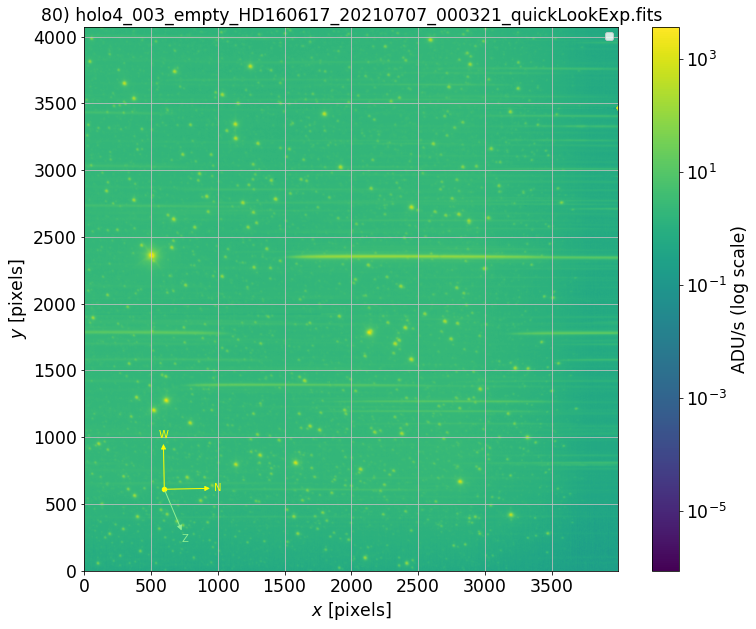

In [325]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [326]:
filename_image

'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

In [327]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (500.0,2300.0)


## Let Spectractor find the location of the 0th order

2021-10-14 11:51:01  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1        
    ------------------ -------------------- --------------------
    1.9431666267917787 0.003396306004393978 0.018113417658333984
2021-10-14 11:51:02  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 25 iterations because the relative change of cost is below ftol=1.25e-05.


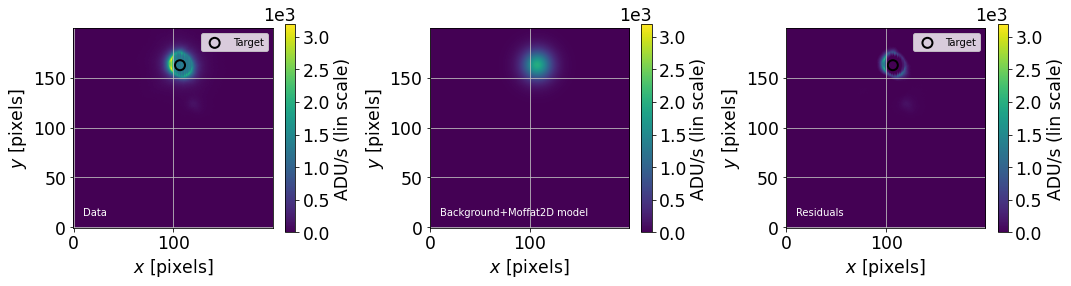

2021-10-14 11:51:04  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=5.681818181818182e-05.


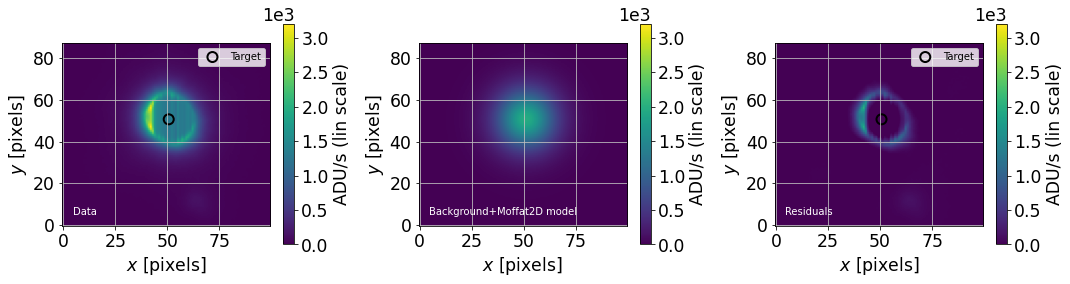

2021-10-14 11:51:05  Image      find_target          INFO   
	X,Y target position in pixels: 506.684,2362.666


In [328]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [329]:
print(x1,y1)

506.6842389389115 2362.6664395113107


## Check the location of 0th order and Analysis of the quality of its focus

In [330]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [331]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [332]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [333]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [334]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [335]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [336]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [337]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [338]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [339]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [340]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [341]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [342]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-343-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '80) holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits')

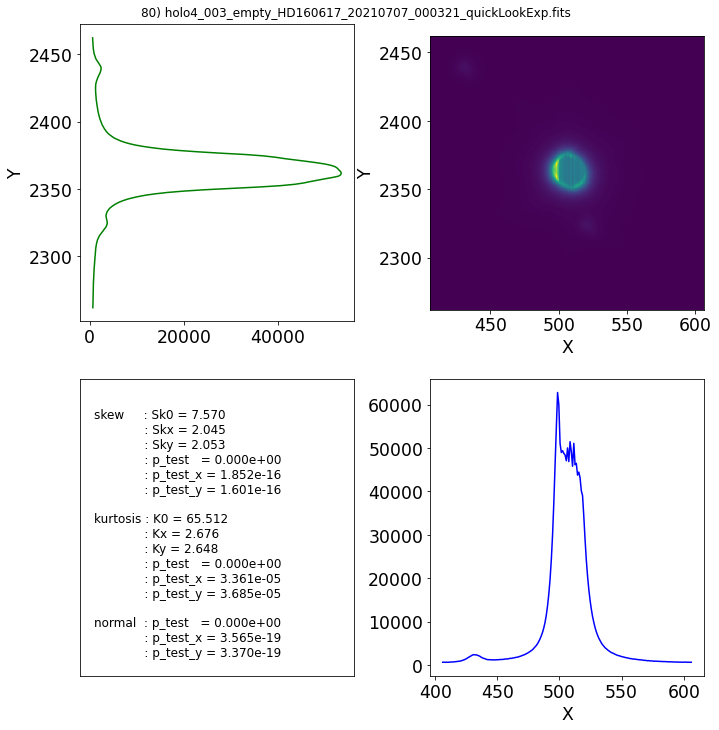

In [343]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [344]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [345]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

2021-10-14 11:51:06  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-10-14 11:51:06  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits...
2021-10-14 11:51:06  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-10-14 11:51:07  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-10-14 11:51:07  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-10-14 11:51:07  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-10-14 11:51:11  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---

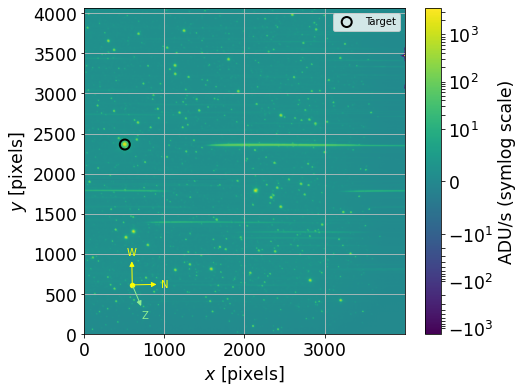

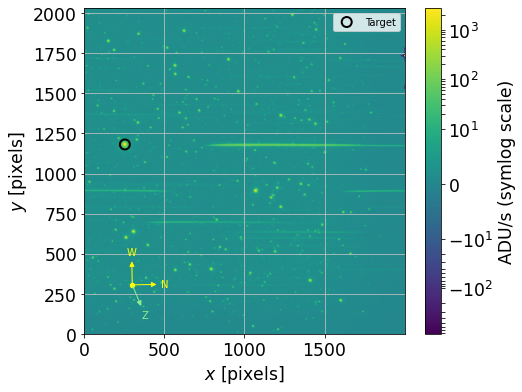

2021-10-14 11:51:18  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 253.34211947 1181.33321976]...
2021-10-14 11:51:18  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                   c0_1        
    ------------------ ---------------------- ---------------------
    4.8055376487814305 -0.0041641694849839555 0.0015918386417127675
2021-10-14 11:51:18  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 8 iterations because the relative change of cost is below ftol=5e-05.


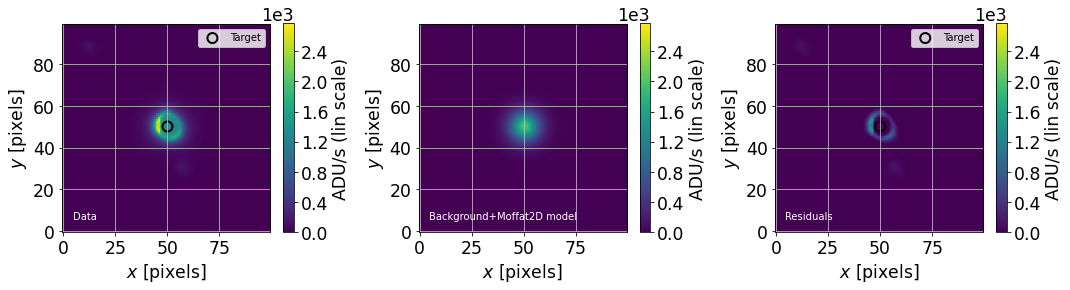

2021-10-14 11:51:19  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


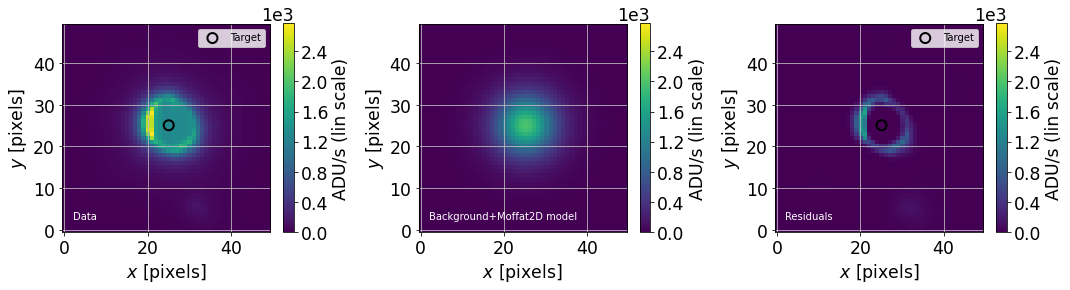

2021-10-14 11:51:20  Image      find_target          INFO   
	X,Y target position in pixels: 253.090,1181.097
2021-10-14 11:51:20  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


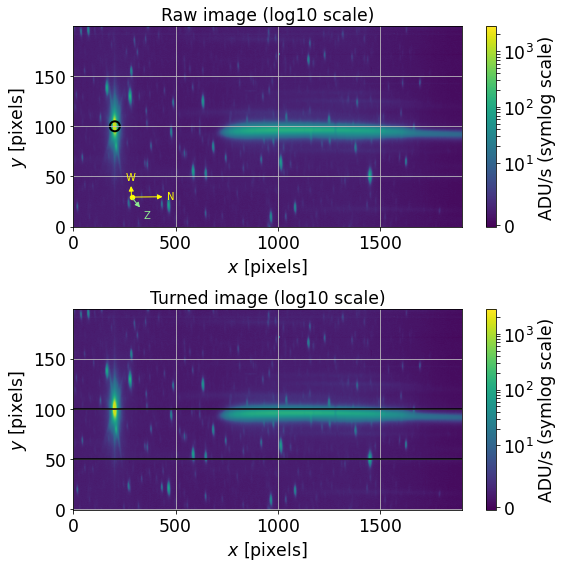

2021-10-14 11:51:25  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-10-14 11:51:25  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                 c0_1         
    ----------------- ------------------- ----------------------
    16.78077806900996 0.10822829893228571 -0.0011246315850706112
2021-10-14 11:51:25  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 7 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


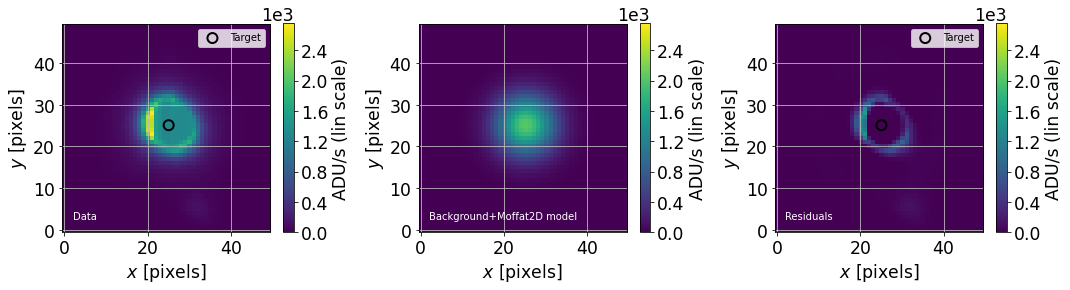

2021-10-14 11:51:27  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


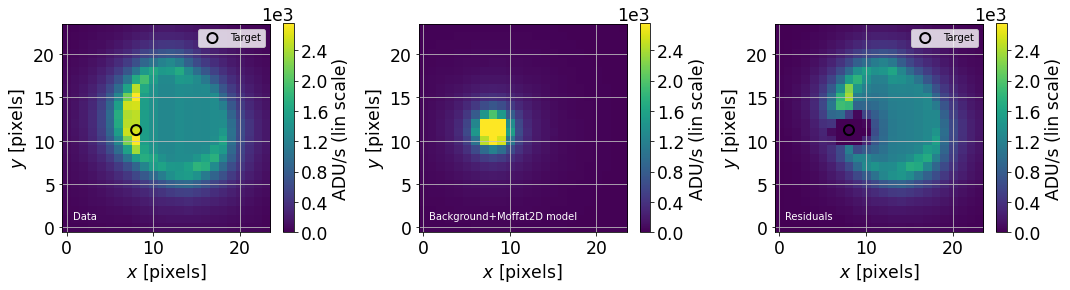

2021-10-14 11:51:28  Image      find_target          INFO   
	X,Y target position in pixels: 249.027,1180.228
2021-10-14 11:51:28  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-10-14 11:51:28  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-10-14 11:51:28  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [675:1833,1090:1270] (size (1158, 180))


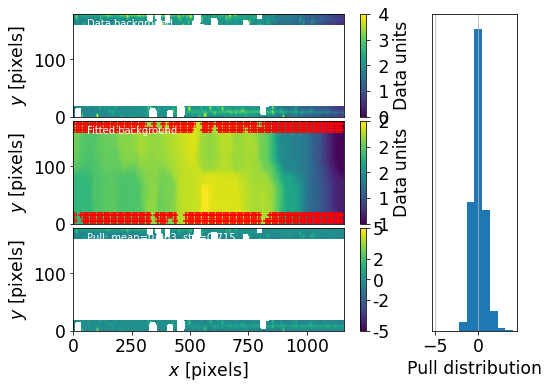

2021-10-14 11:51:30  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


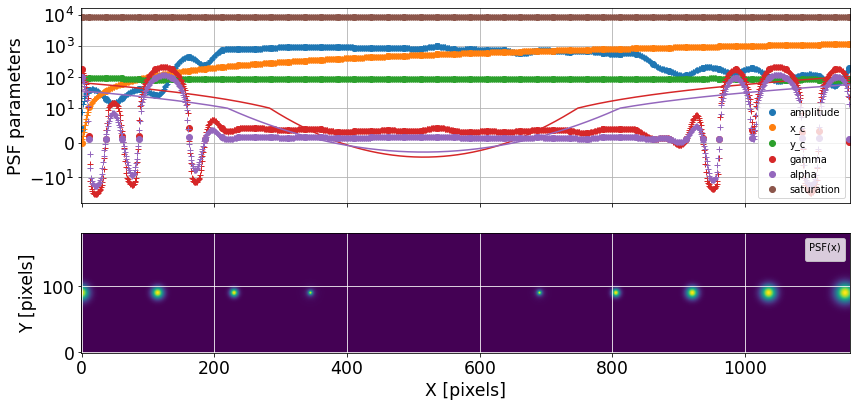

2021-10-14 11:51:35  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=7.4673e+05 initial chisq_red=16.121
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ -0.46113982  -0.45324465  -1.03160295  -5.88879672  -4.91465782
 -12.84580588  -4.01184422  -3.48859597  -9.05457628]
	New parameters: [-4.41354167 -1.17654066 -2.40077323  6.17014793  2.50207664  8.05284983
  2.12212234  0.72175509  2.224988  ]
	Final cost=2.9353e+05 final chisq_red=6.3371 computed in 0.89s
2021-10-14 11:51:36  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=2.9353e+05 initial chisq_red=6.3371
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.09149138  0.10861403  0.11701778 -1.60703538 -1.61163169 -3.7829808
 -0.23294243 -0.30683088 -0.61582884]
	New parameters: [-4.3220503  -1.06792663 -2.28375545  4.56311254  0.89044495  4.26986903
  1.88917991  0.41492421  1.60915916]
	Final cost=1.5757e+05 final chisq_red=3.4018 co

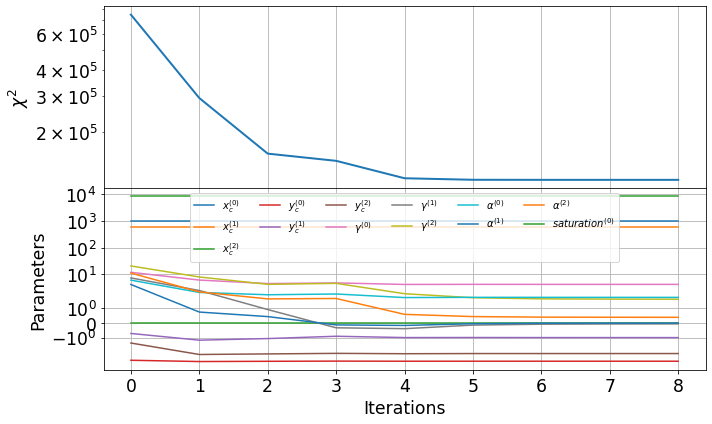

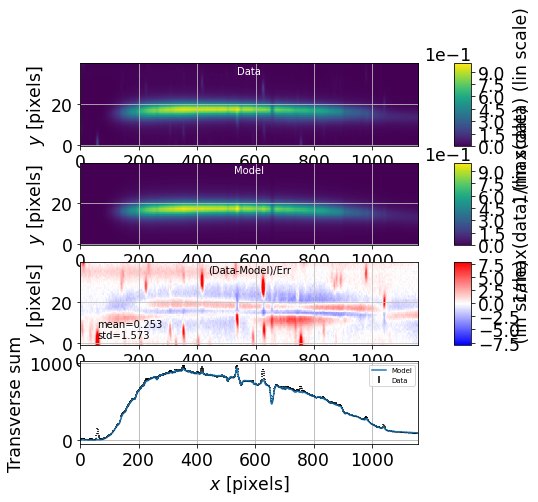

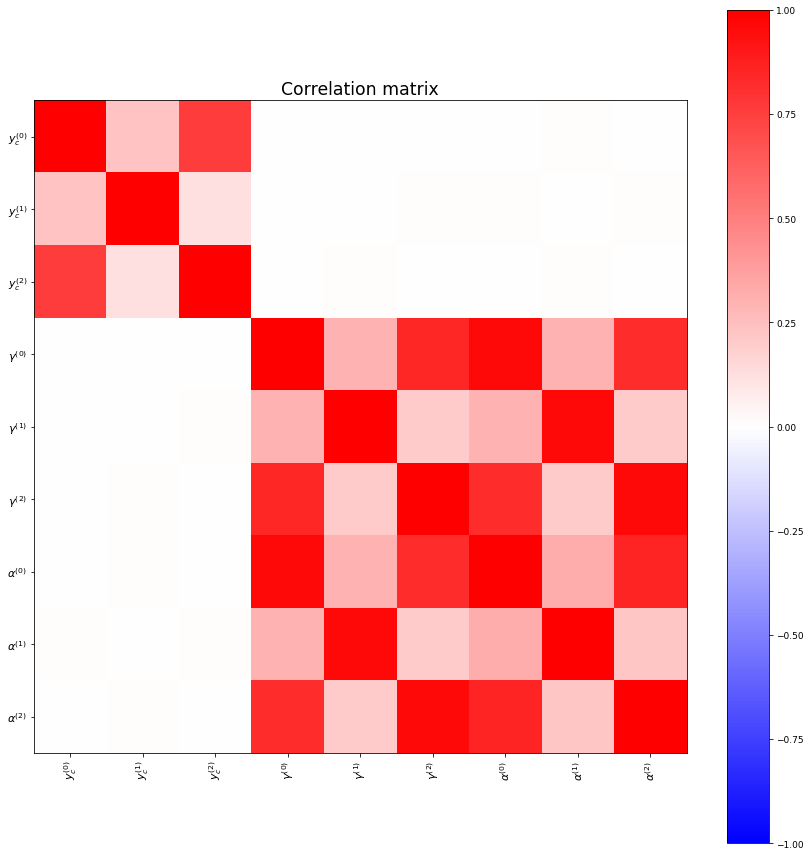

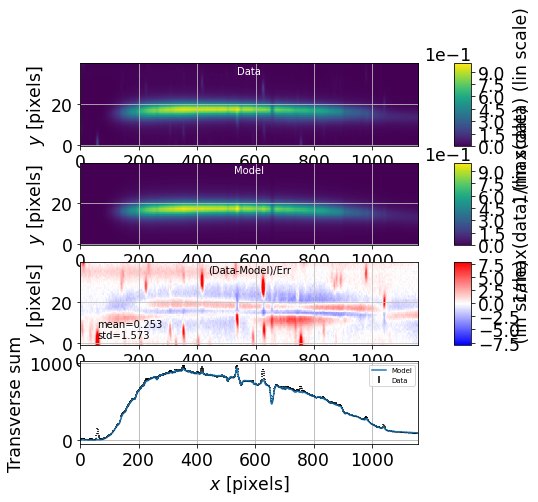

2021-10-14 11:51:48  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
    amplitude       x_c          y_c        ...          Dy         Dy_disp_axis
------------------ ------ ----------------- ... ------------------- ------------
 6.998149202022034    0.0 84.72383348514964 ... -5.5042451635907526          0.0
  7.00787795819557    1.0 84.73356900017566 ...   -5.49450964856473          0.0
 4.098355139212327    2.0 84.74328467428403 ...  -5.484793974456366          0.0
 7.519301435302896    3.0 84.75298050747473 ...  -5.475098141265661          0.0
 4.500995635231364    4.0  84.7626564997478 ...  -5.465422148992587          0.0
7.2982246558471475    5.0 84.77231265110322 ...  -5.455765997637172          0.0
  6.84382841544424    6.0 84.78194896154099 ...  -5.446129687199402          0.0
 6.262541325921572    7.0 84.79156543106112 ...  -5.436513217679277          0.0
 6.661272511934924    8.0  84.8011620596636 ... -5.426916589

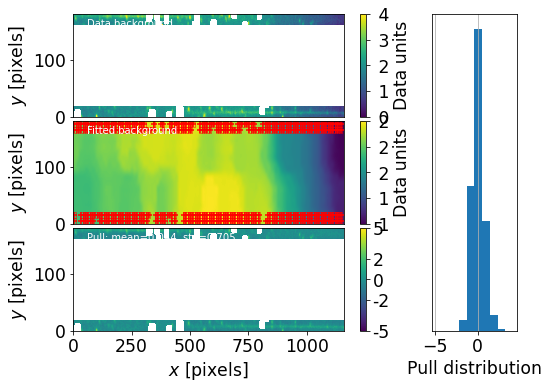

2021-10-14 11:51:50  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=1.978 ADU/s, RMS=0.281 ADU/s.
2021-10-14 11:51:50  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [678:1836,1091:1272] (size (1158, 181))
	New target position in spectrogram frame: [-424.9095644234076, 90.09745569213374]


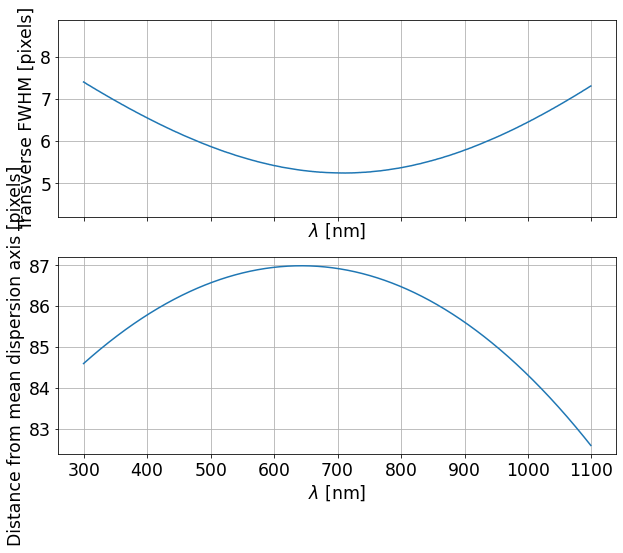

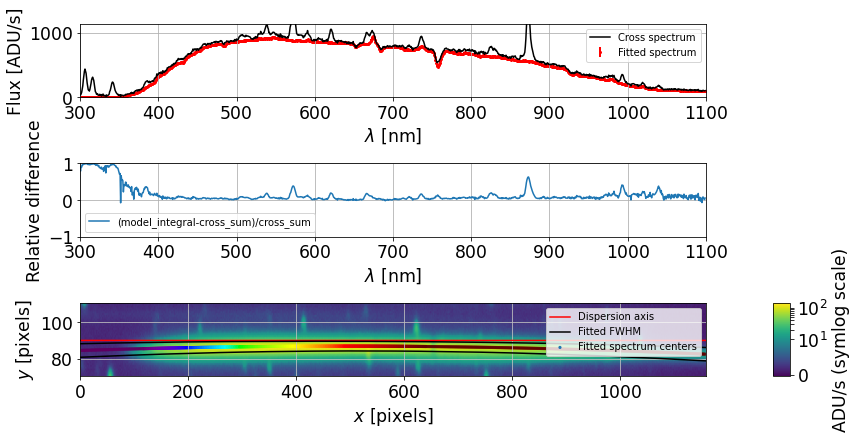

2021-10-14 11:51:52  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


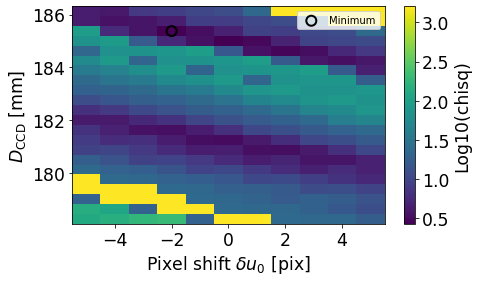

2021-10-14 11:52:19  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.996pix
	D = 185.375 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, 4.5 sigma shift)
2021-10-14 11:52:21  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-10-14 11:52:38  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.4473e+06 initial chisq_red=157.37
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [-1.11091226 -0.2363677 ]
	New parameters: [-1.11091226 -0.2363677 ]
	Final cost=1.4589e+06 final chisq_red=35.612 computed in 14.44s
2021-10-14 11:52:52  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.4589e+06 initial chisq_red=35.612
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [0.83621715 0.01665853]
	New parameters: [-0.27469511 -0.21970916]
	Final cost=9.926e+05 final chisq_red=24.229 computed in 13.80s
2021-10-14 11:53:0

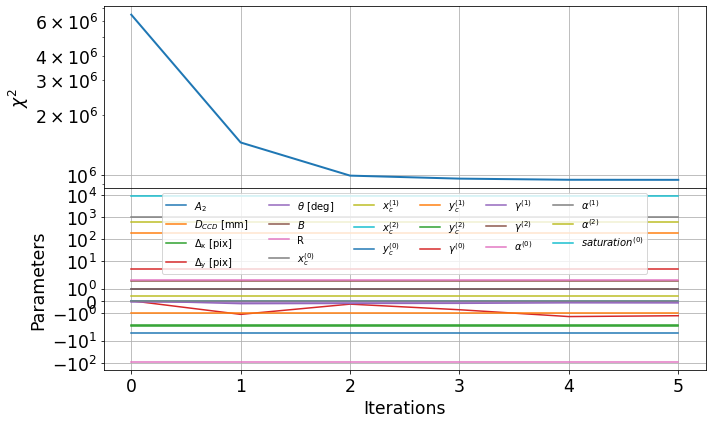

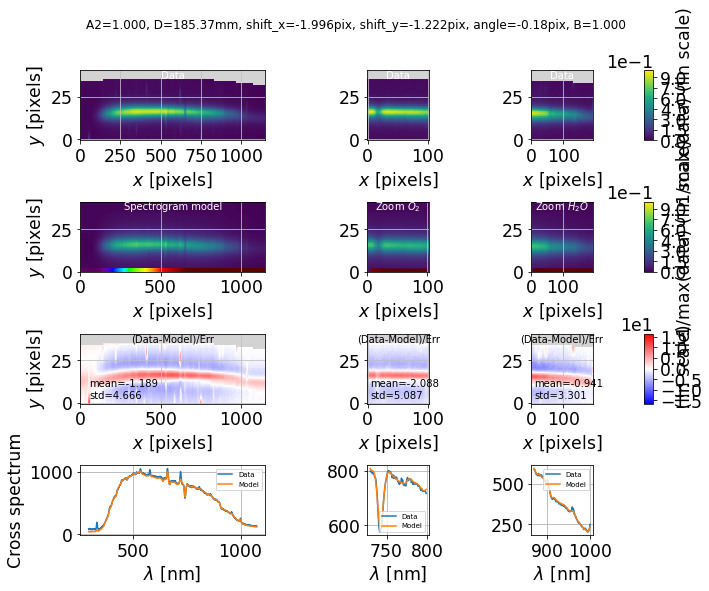

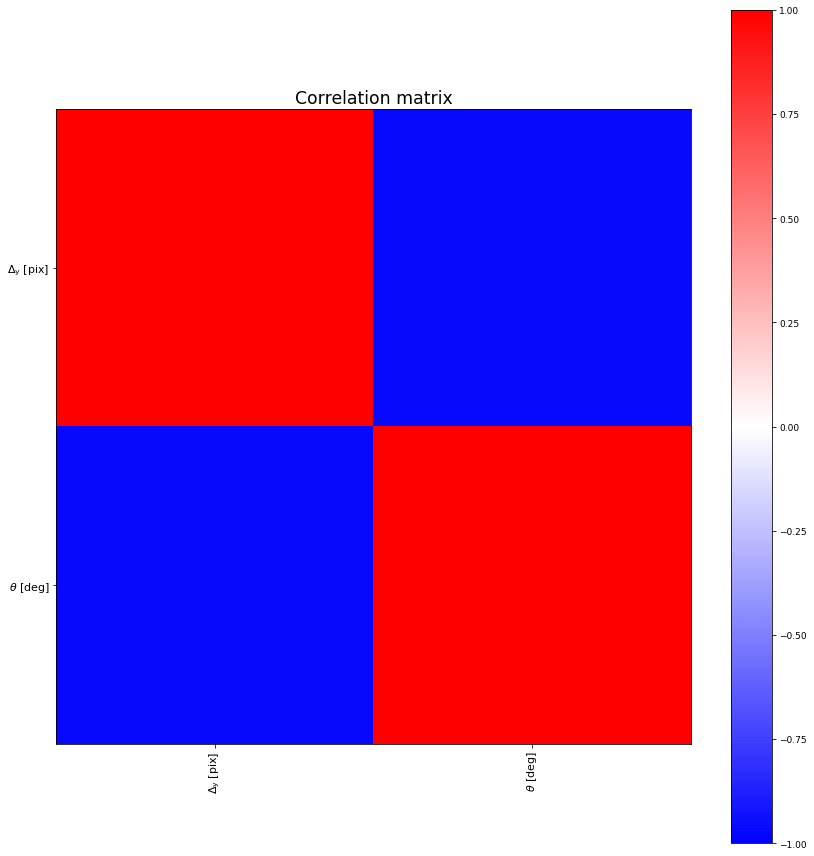

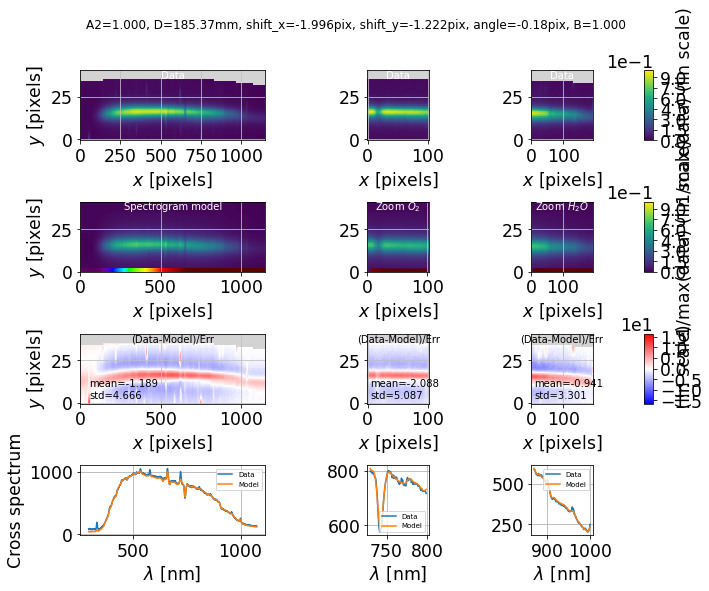

2021-10-14 11:53:45  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.85375000e+02 -1.99554286e+00 -1.22222942e+00
 -1.76409187e-01  1.00000000e+00 -8.88856424e+01  1.00447277e+03
  5.78500000e+02 -9.87831458e-14 -4.29318150e+00 -1.00227171e+00
 -2.21333538e+00  4.25437063e+00 -7.65461097e-02  1.58867482e+00
  1.71236486e+00 -2.37077064e-02  3.66529888e-01  8.50000000e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-10-14 11:54:10  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=9.4512e+05 initial chisq_red=23.07
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.0266004   0.00595369 -1.10934929 -0.34275223 -0.01209432  0.13094858
 -0.04798907  0.0324677 ]
	New parameters: [-1.24882982 -0.1704555   3.14502134 -0.

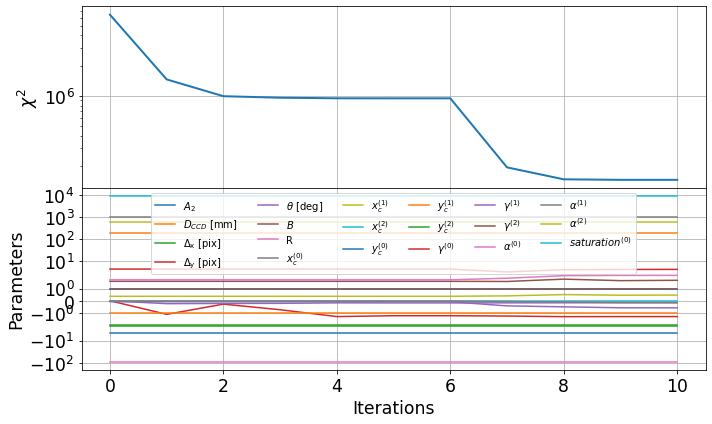

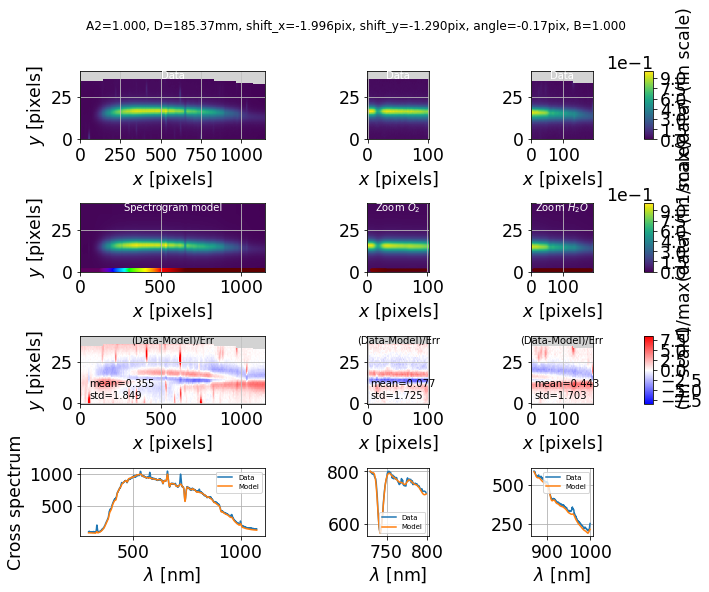

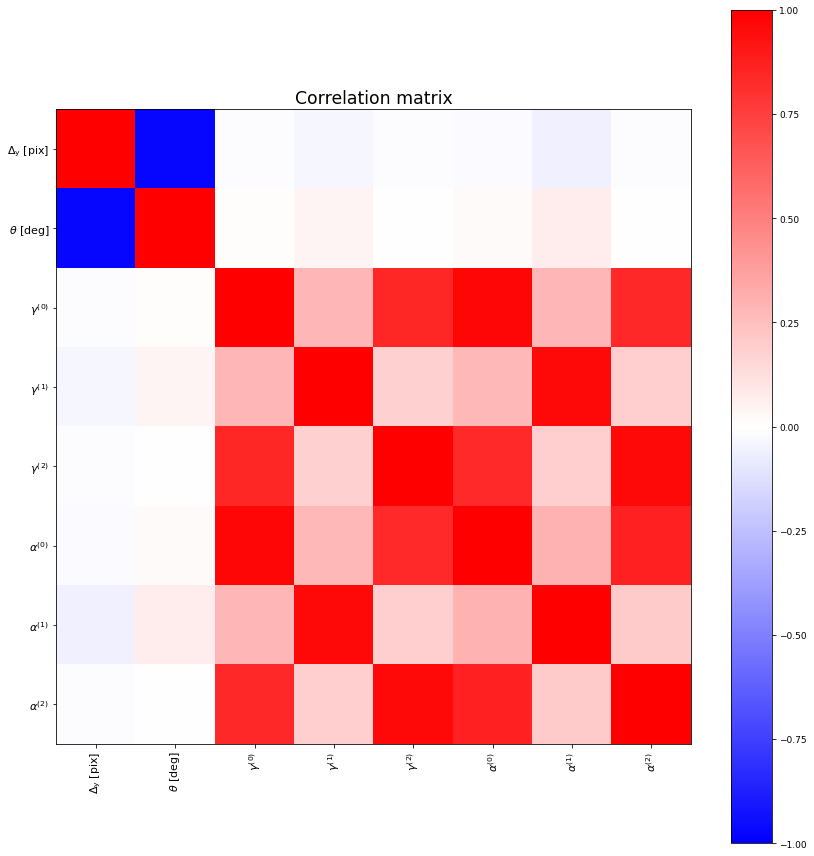

2021-10-14 11:55:26  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-10-14 11:55:35  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[-0.199125 ],
       [-0.1991875]]), array([3.84506031e-09, 3.84506031e-09]))
           fun: 3.845060305875771e-09
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 20
        status: 0
       success: True
             x: array([-0.199125])
2021-10-14 11:55:35  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 8.587999820709229s


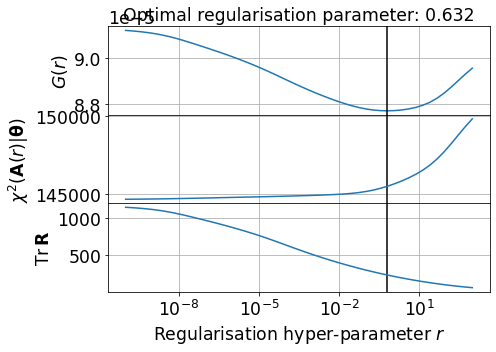

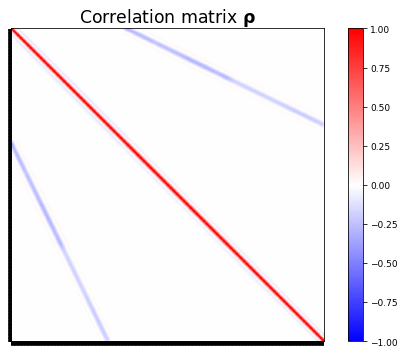

2021-10-14 11:56:03  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 0.6322298548061861
	Tr(R) = 235.91672593982884
	N_params = 1158
	N_data = 40968 (without mask and outliers)
2021-10-14 11:56:29  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.4503e+05 initial chisq_red=3.5428
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 4.55331904e-04 -4.68322110e-05  1.06558794e-03  1.12817916e-02
  3.28696034e-02 -5.89158766e-04  4.60979124e-03  1.89629056e-02]
	New parameters: [-1.29002993 -0.16656878  4.11564567 -0.56749111  1.70489966  2.20523899
 -0.14212791  0.48620559]
	Final cost=1.4501e+05 final chisq_red=3.5423 computed in 19.61s
2021-10-14 11:56:55  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.4501e+05 initial chisq_red=3.5423
		 Line search: alpha_min=0.0344 iter=5 funcalls=9
	Parameter shifts: [ 4.29696045e-04 -2.40885453e-05 -1.48157837e-04  3.51407973e-05

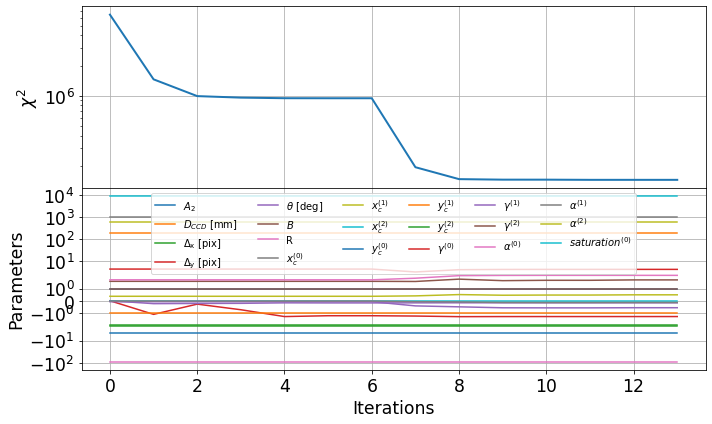

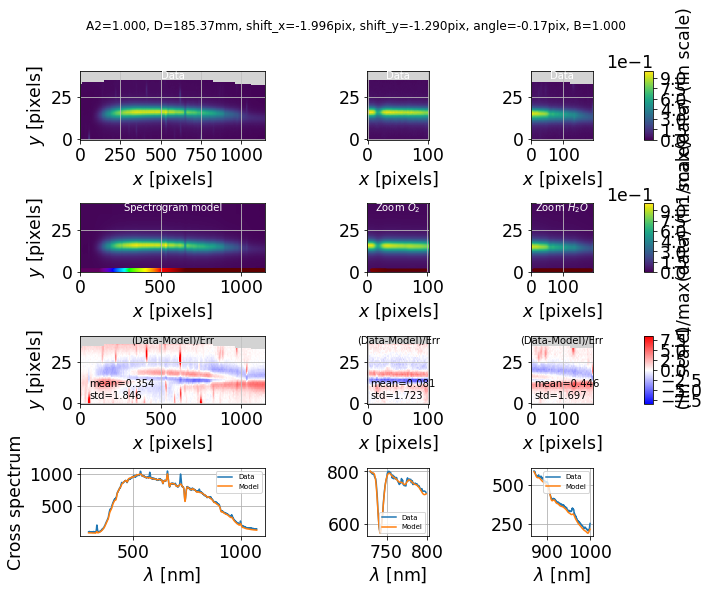

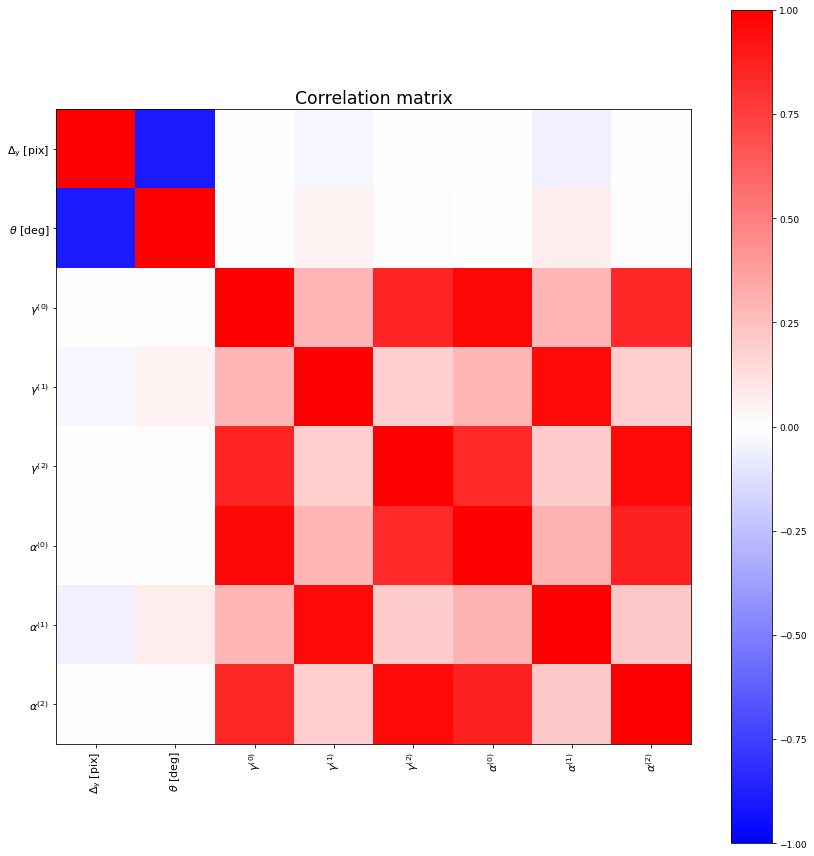

2021-10-14 11:57:01  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [54, 55, 56, 57, 1213, 1214, 1215]
2021-10-14 11:57:01  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 7 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-10-14 11:57:28  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.4157e+05 initial chisq_red=3.4584
		 Line search: alpha_min=0.0171 iter=5 funcalls=9
	Parameter shifts: [-2.87771967e-04  1.74203202e-05 -6.84173313e-05  1.82564326e-05
 -1.92390410e-04 -3.08455789e-05  1.93614864e-05 -9.24524183e-05]
	New parameters: [-1.28988801 -0.16657544  4.11542909 -0.56743772  1.70430092  2.20513251
 -0.14211377  0.4859088 ]
	Final cost=1.4157e+05 final chisq_red=3.4584 computed in 25.22s
2021-10-14 11:57:53  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.4157e+05 initial chisq_red=3.4584
		 Line search: alpha_min=0.0417

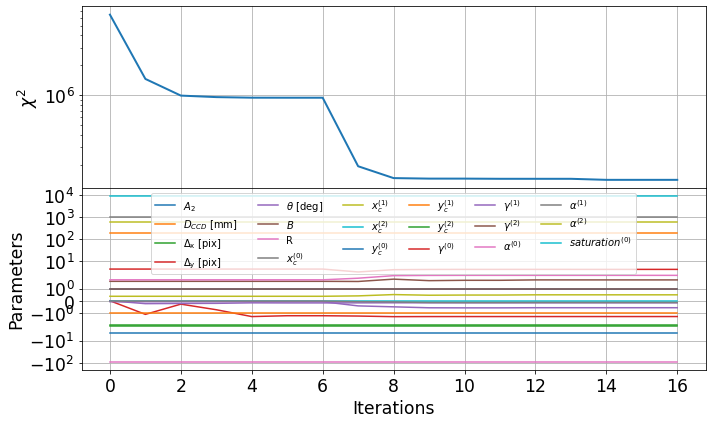

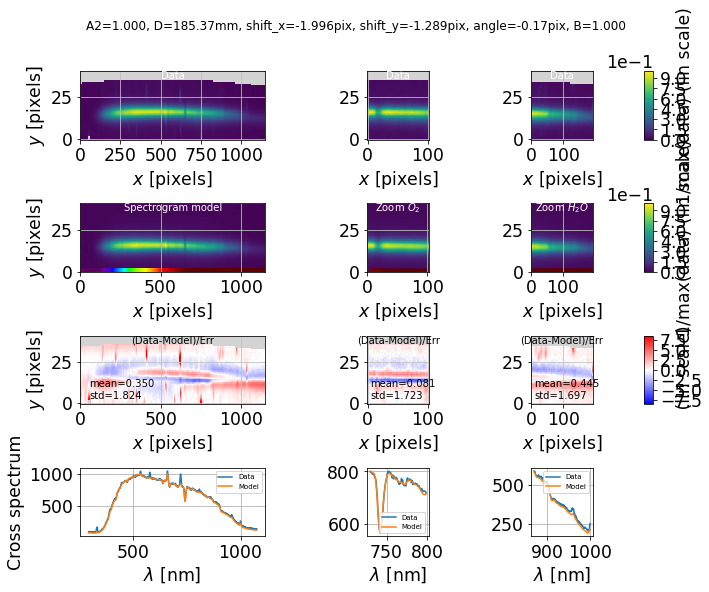

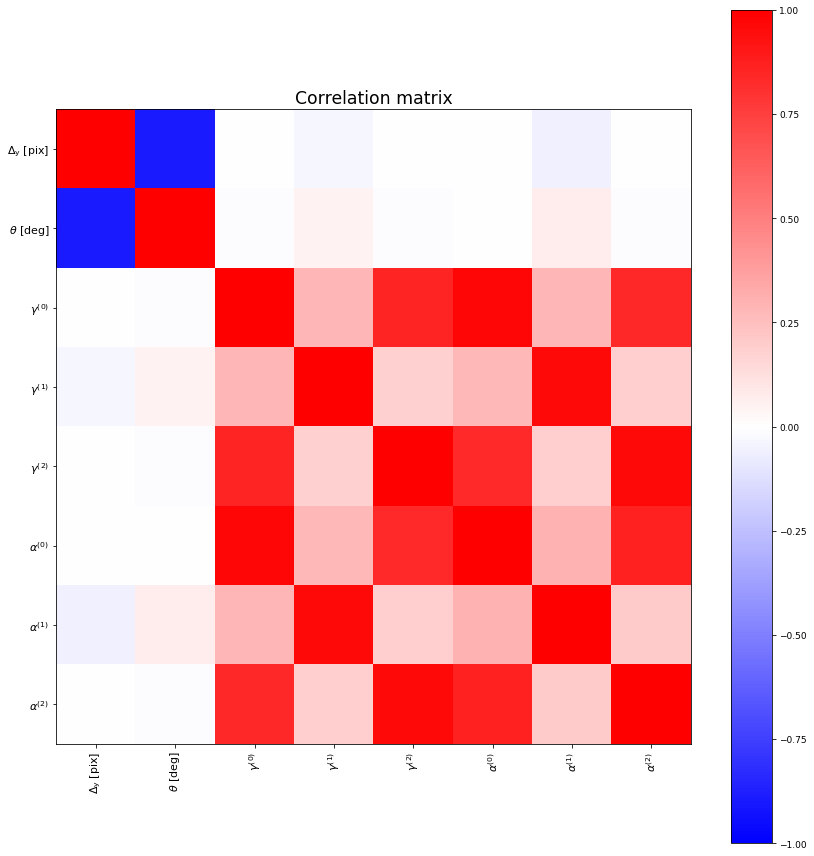

2021-10-14 11:57:59  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [54, 55, 56, 57, 1213, 1214, 1215]
2021-10-14 11:57:59  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 7 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-10-14 11:57:59  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-10-14 11:57:59  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 253.94965076446533s


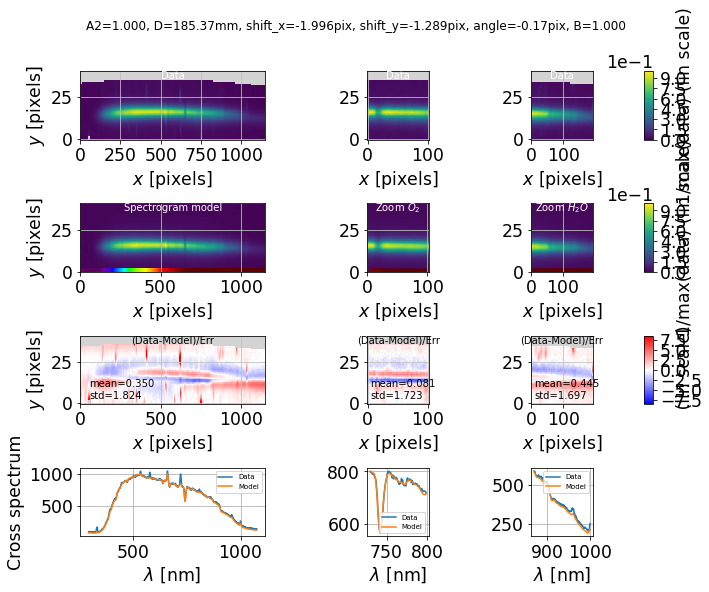

2021-10-14 11:58:18  Spectrum   calibrate_spectrum   WARNING 
	Minimum chisq is on the edge of the exploration grid.


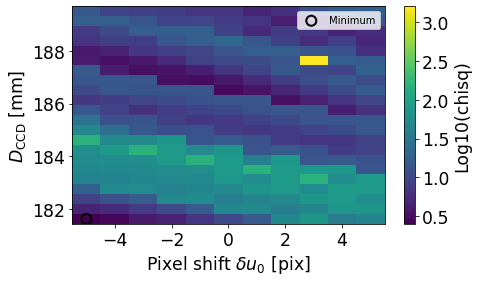

2021-10-14 11:58:21  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -2.000pix
	D = 181.031 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -1.3 sigma shift)
2021-10-14 11:58:46  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5739e+05 initial chisq_red=3.8448
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.05169803 -0.00187309 -0.00453756  0.05354105 -0.0353833  -0.01558698
  0.00980776 -0.03878392]
	New parameters: [-1.34106283 -0.16847801  4.11067081 -0.51409425  1.66835591  2.18943455
 -0.132422    0.44684496]
	Final cost=1.5034e+05 final chisq_red=3.6726 computed in 20.50s
2021-10-14 11:59:07  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5034e+05 initial chisq_red=3.6726
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [ 0.02139814 -0.00035709  0.03761357  0.07625437 -0.08335224  0.02502156
  0.03568238 -0.00571818]
	New parameters: [-1.31966469 -0.16883509  4.

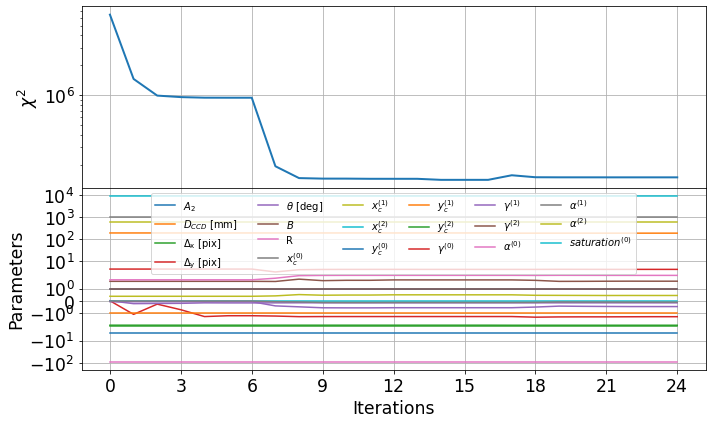

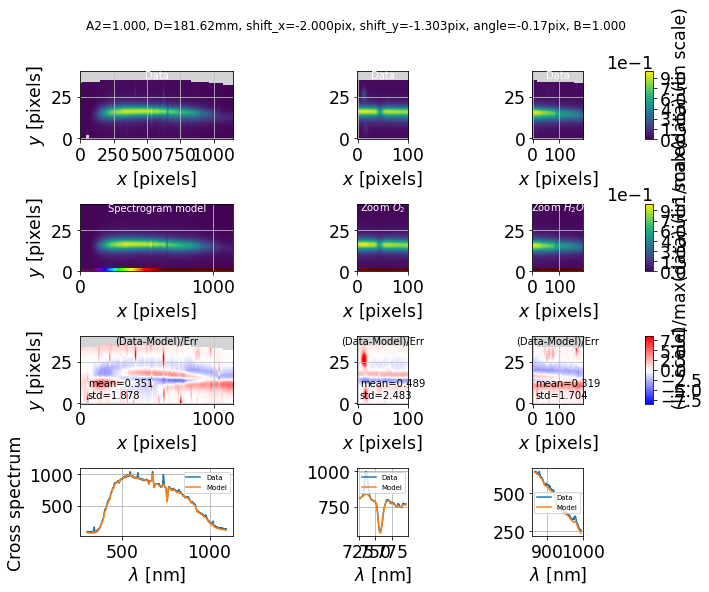

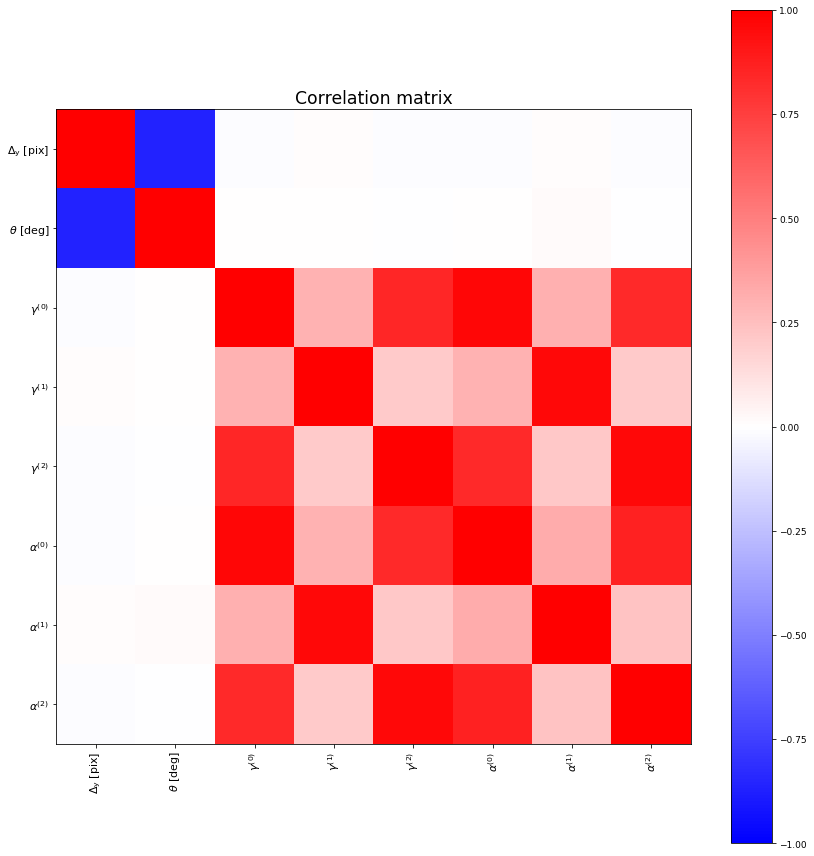

2021-10-14 12:01:09  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [54, 55, 56, 57, 1213, 1214, 1215]
2021-10-14 12:01:09  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 7 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-10-14 12:01:09  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-10-14 12:01:09  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 444.2636079788208s


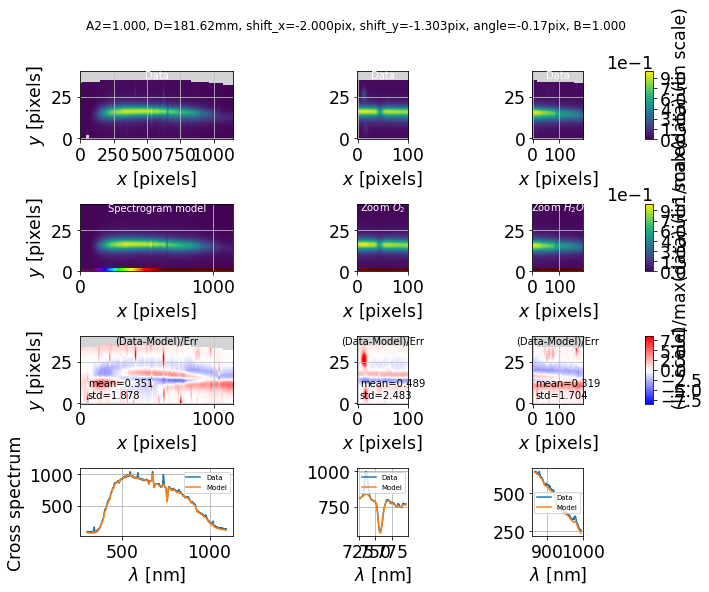

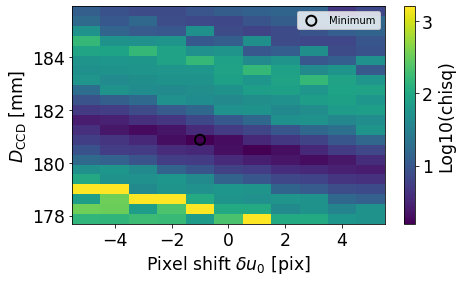

2021-10-14 12:01:29  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.062pix
	D = 180.700 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -1.7 sigma shift)
2021-10-14 12:01:31  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-10-14 12:01:31  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-10-14 12:01:31  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits
2021-10-14 12:01:31  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrogram.fits


   Line   Tabulated  Detected ...   Chisq    Eqwidth_mod Eqwidth_data
              nm        nm    ...  reduced        nm          nm     
--------- --------- --------- ... ---------- ----------- ------------
 $Fe_{I}$ 430.93433  432.2325 ...  1.5942762  0.34977323   0.34720156
$H\gamma$  434.1454  434.7784 ...  1.5942762  0.09480964   0.32891864
 $H\beta$ 486.46292 486.04318 ... 0.47516796   0.3693314   0.32284167
$H\alpha$ 656.51984 656.11383 ...  6.3006115  0.36502555   0.30987763
 $O_2(B)$   687.472 687.92554 ...  6.3006115   1.4304507      1.14564
              760.3 760.28143 ...  0.8860874   1.6496172    3.3530064
    $O_2$     763.1  763.0207 ...  0.8860874   1.7341743     3.366475
 $O_2(Y)$   898.765  898.5894 ... 0.24420312   0.4724829   0.47765812
  $H_2 O$     935.0  933.2848 ...  2.4619024   3.0479722    1.3907304


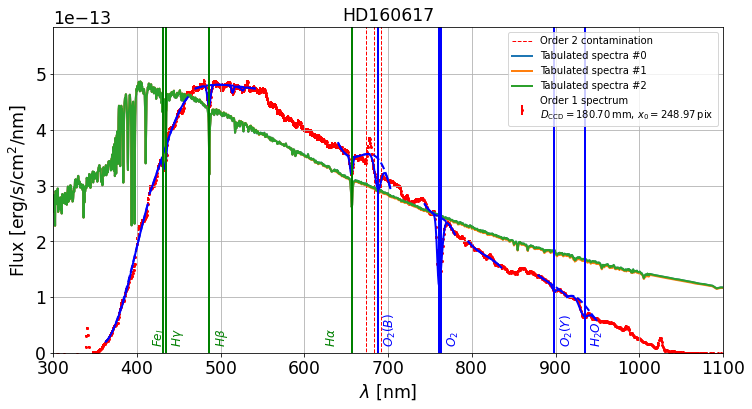

In [346]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
#spectrum = Spectractor(filename_image, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Backup output

In [347]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits']

In [348]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/